In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TODO : write a lidar file path, an img flie and calib file path
lidar_path = './0000000015.bin'
img_path = './0000000015.png'
v2c_filepath = './calib_velo_to_cam.txt'
c2c_filepath = './calib_cam_to_cam.txt'
# TODO : mode means cam number , i.e) cam_00 's mode is 00
mode = '00'
v_fov = (-24.9, 2.0)
h_fov = (-45, 45)

In [3]:
h_fov[1:]

(45,)

In [4]:
# load lidar file(.bin)
def load_bin(bin_path):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points[:, :3]


velo_points = load_bin(lidar_path)

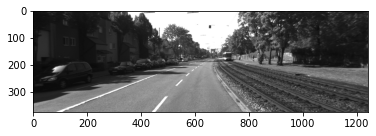

In [5]:
# load img file
image = cv2.imread(img_path)
width, height = image.shape[:2]
plt.imshow(image)

In [6]:
def depth_color(val, min_d=0, max_d=120):
    """ 
    print Color(HSV's H value) corresponding to distance(m) 
    close distance = red , far distance = blue
    """
    np.clip(val, 0, max_d, out=val)  # max distance is 120m but usually not usual
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8)


def in_h_range_points(points, m, n, fov):
    """ extract horizontal in-range points """
    return np.logical_and(np.arctan2(n, m) > (-fov[1] * np.pi / 180),
                          np.arctan2(n, m) < (-fov[0] * np.pi / 180))


def in_v_range_points(points, m, n, fov):
    """ extract vertical in-range points """
    return np.logical_and(np.arctan2(n, m) < (fov[1] * np.pi / 180),
                          np.arctan2(n, m) > (fov[0] * np.pi / 180))


def fov_setting(points, x, y, z, dist, h_fov, v_fov):
    """ filter points based on h,v FOV  """

    if h_fov[1] == 180 and h_fov[0] == -180 and v_fov[1] == 2.0 and v_fov[0] == -24.9:
        return points

    if h_fov[1] == 180 and h_fov[0] == -180:
        return points[in_v_range_points(points, dist, z, v_fov)]
    elif v_fov[1] == 2.0 and v_fov[0] == -24.9:
        return points[in_h_range_points(points, x, y, h_fov)]
    else:
        h_points = in_h_range_points(points, x, y, h_fov)
        v_points = in_v_range_points(points, dist, z, v_fov)
        return points[np.logical_and(h_points, v_points)]


def velo_points_filter(points, v_fov, h_fov):
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    dist = np.sqrt(x**2+y**2+z**2)

    if h_fov[0] < -90:
        h_fov = (-90,) + h_fov[1:]
    if h_fov[1] > 90:
        h_fov = h_fov[:1] + (90,)

    x_lim = fov_setting(x, x, y, z, dist, h_fov, v_fov)[:, None]
    y_lim = fov_setting(y, x, y, z, dist, h_fov, v_fov)[:, None]
    z_lim = fov_setting(z, x, y, z, dist, h_fov, v_fov)[:, None]

    # Stack arrays in sequence horizontally
    xyz_ = np.hstack((x_lim, y_lim, z_lim))
    xyz_ = xyz_.T

    # stack (1,n) arrays filled with the number 1
    one_mat = np.full((1, xyz_.shape[1]), 1)
    xyz_ = np.concatenate((xyz_, one_mat), axis=0)

    # need dist info for points color
    dist_lim = fov_setting(dist, x, y, z, dist, h_fov, v_fov)
    color = depth_color(dist_lim, 0, 70)

    return xyz_, color

In [7]:
def calib_velo2cam(filepath):
    """ 
    get Rotation(R : 3x3), Translation(T : 3x1) matrix info 
    using R,T matrix, we can convert velodyne coordinates to camera coordinates
    """
    with open(filepath, "r") as f:
        file = f.readlines()
    
        for line in file:
            try:
                (key, val) = line.split(':', 1)
                if key == 'R':
                    R = np.fromstring(val, sep=' ')
                    R = R.reshape(3, 3)
                if key == 'T':
                    T = np.fromstring(val, sep=' ')
                    T = T.reshape(3, 1)
            except:
                print("except")
    return R, T


def calib_cam2cam(filepath, mode):
    """
    If your image is 'rectified image' :
        get only Projection(P : 3x4) matrix is enough
    but if your image is 'distorted image'(not rectified image) :
        you need undistortion step using distortion coefficients(5 : D)

    in this code, I'll get P matrix since I'm using rectified image
    """
    with open(filepath, "r") as f:
        file = f.readlines()

        for line in file:
            try:
                (key, val) = line.split(':', 1)
                if key == ('P_rect_' + mode):
                    P_ = np.fromstring(val, sep=' ')
                    P_ = P_.reshape(3, 4)
                    # erase 4th column ([0,0,0])
                    P_ = P_[:3, :3]
            except:
                print("except")
    return P_

In [12]:
# R_vc = Rotation matrix (lidar -> cam)# R_vc = Rotation matrix (lidar -> cam)
# T_vc = Translation matrix (lidar -> cam)
# P_ = projection_matrix(cam 3d points -> img 2d points)

def velo3d_2_camera2d_points(points, vc_path, cc_path, mode, v_fov, h_fov):
    R_vc, T_vc = calib_velo2cam(vc_path)
    P = calib_cam2cam(cc_path, mode)

    xyz_v, c_ = velo_points_filter(points, v_fov, h_fov)

    """    
            [r_11 , r_12 , r_13 , t_x ]
    RT   =  [r_21 , r_22 , r_23 , t_y ]   
            [r_31 , r_32 , r_33 , t_z ]
    """
    RT = np.concatenate((R_vc, T_vc), axis=1)
    # convert velodyne coordinates(X_v, Y_v, Z_v) to camera coordinates(X_c, Y_c, Z_c)

    for i in range(xyz_v.shape[1]):
        xyz_v[:3, i] = np.matmul(RT, xyz_v[:, i])

    xyz_c = np.delete(xyz_v, 3, axis=0)

    # convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y)
    for i in range(xyz_c.shape[1]):
        xyz_c[:, i] = np.matmul(P, xyz_c[:, i])

    """
    xy_i - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates before scale adjustment
    ans  - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates
             [s_1*x_1 , s_2*x_2 , .. ]
    xy_i =   [s_1*y_1 , s_2*y_2 , .. ]        ans =   [x_1 , x_2 , .. ]  
             [  s_1   ,   s_2   , .. ]                [y_1 , y_2 , .. ]
    """
    xy_i = xyz_c[::]/xyz_c[::][2]
    ans = np.delete(xy_i, 2, axis=0)
    """
    width = 1242
    height = 375
    w_range = in_range_points(ans[0], width)
    h_range = in_range_points(ans[1], height)

    ans_x = ans[0][np.logical_and(w_range,h_range)][:,None].T
    ans_y = ans[1][np.logical_and(w_range,h_range)][:,None].T
    c_ = c_[np.logical_and(w_range,h_range)]

    ans = np.vstack((ans_x, ans_y))
    """

    return ans, c_

(2, 30326)


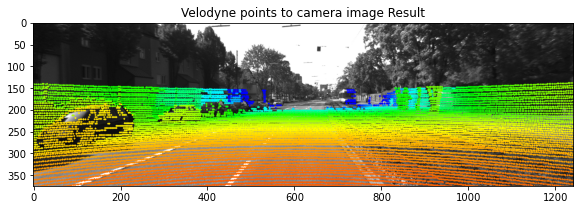

In [13]:
def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]), np.int32(
            points[1][i])), 2, (int(color[i]), 255, 255), -1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)


image = cv2.imread(img_path)
ans, c_ = velo3d_2_camera2d_points(velo_points, v2c_filepath,
                                   c2c_filepath, mode, v_fov, h_fov)
image = print_projection_plt(points=ans, color=c_, image=image)
plt.subplots(1, 1, figsize=(13, 3))
plt.title("Velodyne points to camera image Result")
plt.imshow(image)